<a href="https://colab.research.google.com/github/Lucia1009/TFG-Red-neuronal-turbinas-eolicas/blob/desarrollo/pruebas_hiperpar%C3%A1metros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install darts -q
!pip install dash -q
!pip install tensorflow_decision_forests -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math


from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import R2Score
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go



(21600, 150)
(216000, 150)


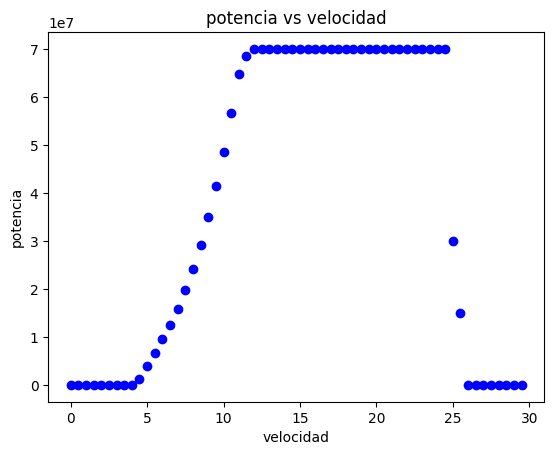

360


In [ ]:
df=pd.read_csv('elvalle_reparto_saltos_sp75.csv', delimiter=";",decimal=".",skiprows = [1])

df_filtrado=df[(df['TIME'] % 600==540)]
print(df_filtrado.shape)
print(df.shape)

# unique_wd, counts = np.unique(df_filtrado['wd'], return_counts=True)
# print(counts, "\n", unique_wd )

direcciones={}
for i in range(0,360):
    # Separo los datos para cada dirección
    filtered_data = df_filtrado[(df_filtrado['wd'] <= i) & (df_filtrado['wd'] > (i - 1 ))]

    # Selecciono solo las columnas que me interesan
    selected_columns = filtered_data[['ws', 'WF_Power', 'wd']]

    direcciones[i]=selected_columns
    # print(i, direcciones[i])

plt.title("potencia vs velocidad")
plt.scatter(direcciones[1]['ws'], direcciones[1]['WF_Power'], color="blue")

plt.xlabel("velocidad")
plt.ylabel("potencia")
plt.show()
print(len(direcciones))

In [ ]:
datos = pd.DataFrame(df_filtrado[['wd', 'ws', 'WF_Power']])

datos['sin_wd'] = np.sin(datos['wd']*np.pi/180)
datos['cos_wd'] = np.cos(datos['wd']*np.pi/180)
datos = datos.drop('wd', axis=1)


datos.tail()

,ws,WF_Power,sin_wd,cos_wd
215959,27.500000,1.157064e-41,-0.017452,0.999848
215969,28.000000,-1.711043e-52,-0.017452,0.999848
215979,28.500000,6.197535e-59,-0.017452,0.999848
215989,29.000000,7.481889e-71,-0.017452,0.999848
215999,29.500001,-1.019971e-84,-0.017452,0.999848


## Prueba hiperparámetros polinomial

In [ ]:
datos_train = []
datos_test = []
for i in range(datos.shape[0]):

  if i%4==0:
      datos_test.append(datos.iloc[i])
  else:
      datos_train.append(datos.iloc[i])

print(len(datos_train), len(datos_test))
print(datos.shape[0]/len(datos_test))
print(datos.shape[0]/4)

print(datos_train[0], "\n", datos_train[1])

datos_train = pd.DataFrame(datos_train)
datos_test = pd.DataFrame(datos_test)

X_train_p = datos_train.drop('WF_Power', axis=1)
y_train_p = datos_train['WF_Power']

X_test_p = datos_test.drop('WF_Power', axis=1)
y_test_p = datos_test['WF_Power']

X_train_p.head(10)

#Transformamos los datos
transformador = Pipeline([('scaler', StandardScaler()),  # normaliza los datos
                  ('poly', PolynomialFeatures(degree=15))]) ################ grado

X_train_p_transf  = transformador.fit_transform(X_train_p)
X_test_p_transf = transformador.transform(X_test_p)

print(X_train_p_transf.shape[1])

### Creamos el modelo ###

def build_model(input_shape):
  model_nn = keras.Sequential([
    keras.layers.Input(shape=(input_shape,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

  model_nn.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'R2Score'])
  return model_nn


# Definir los rangos de los hiperparámetros
param_grid = {
    'grado': [11, 13, 15],
    'epochs':[40]
}

best_mse = float('inf')
best_params = None

# Búsqueda manual de hiperparámetros
for grado in param_grid['grado']:
  for epochs in param_grid['epochs']:
    print(f"Probando grado={grado}, epoch={epochs}")

    #Transformamos los datos
    transformador = Pipeline([('scaler', StandardScaler()),  # normaliza los datos
                      ('poly', PolynomialFeatures(degree=grado))])


    X_train_p_transf  = transformador.fit_transform(X_train_p)
    X_test_p_transf = transformador.transform(X_test_p)

    print('shape',X_train_p_transf.shape[1])



    model_nn = build_model(X_train_p_transf.shape[1])

    #Entrenamos el modelo
    model_nn.fit(X_train_p_transf, y_train_p, epochs=epochs, verbose=0)

    #Evaluamos el modelo
    evaluacion=model_nn.evaluate(X_test_p_transf, y_test_p)


    mse = evaluacion[0]
    print(f"MSE: {mse}")

    # Guardar los mejores parámetros
    if mse < best_mse*1.1:
        best_mse = mse
        best_params =( grado, epochs)

# Mostrar los mejores hiperparámetros y el MSE asociado
print(f"Mejores parámetros: grado={best_params[0]}, epochs={best_params[1]} con MSE={best_mse}")



16200 5400
4.0
5400.0
ws          5.000000e-01
WF_Power    2.704126e-41
sin_wd      0.000000e+00
cos_wd      1.000000e+00
Name: 19, dtype: float64 
 ws          1.000000e+00
WF_Power    1.847847e-58
sin_wd      0.000000e+00
cos_wd      1.000000e+00
Name: 29, dtype: float64
816
Probando grado=11, epoch=40
shape 364
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - R2Score: 0.8947 - loss: 108545332740096.0000 - mae: 7696723.5000 - mse: 108545332740096.0000
MSE: 111937945862144.0
Probando grado=13, epoch=40
shape 560
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - R2Score: 0.9048 - loss: 98071627169792.0000 - mae: 7461311.0000 - mse: 98071627169792.0000
MSE: 98491384725504.0
Probando grado=15, epoch=40
shape 816
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - R2Score: 0.9715 - loss: 29338548305920.0000 - mae: 3370556.0000 - mse: 29338548305920.0000
MSE: 31665103568896.0
Mejores parámetros: grado=15, epochs=40 con MSE=31665103568896.0


## Prueba de hiperparámetros random forest

In [ ]:
datos_train = []
datos_test = []
for i in range(datos.shape[0]):

  if i%4==0:
      datos_test.append(datos.iloc[i])
  else:
      datos_train.append(datos.iloc[i])

print(len(datos_train), len(datos_test))
print(datos.shape[0]/len(datos_test))
print(datos.shape[0]/4)

print(datos_train[0], "\n", datos_train[1])

dftrain = pd.DataFrame(datos_train)
dftest = pd.DataFrame(datos_test)

# Todas las columnas menos el label
using_col_list = [col for col in dftrain.columns if col != 'WF_Power']
print(using_col_list)

feature_list = []
for col in using_col_list:

   feature_list.append(tfdf.keras.FeatureUsage(name=col,semantic=tfdf.keras.FeatureSemantic.NUMERICAL))

trainds = tfdf.keras.pd_dataframe_to_tf_dataset(dftrain, label='WF_Power',task = tfdf.keras.Task.REGRESSION)
testds = tfdf.keras.pd_dataframe_to_tf_dataset(dftest, label='WF_Power',task = tfdf.keras.Task.REGRESSION)


16200 5400
4.0
5400.0
ws          5.000000e-01
WF_Power    2.704126e-41
sin_wd      0.000000e+00
cos_wd      1.000000e+00
Name: 19, dtype: float64 
 ws          1.000000e+00
WF_Power    1.847847e-58
sin_wd      0.000000e+00
cos_wd      1.000000e+00
Name: 29, dtype: float64
['ws', 'sin_wd', 'cos_wd']


In [ ]:
# # Dividir los datos en entrenamiento y prueba
# dftrain, dftest = train_test_split(datos, test_size=0.2)

# # Todas las columnas menos el label
# using_col_list = [col for col in dftrain.columns if col != 'WF_Power']

# feature_list = []
# for col in using_col_list:
#     feature_list.append(tfdf.keras.FeatureUsage(name=col, semantic=tfdf.keras.FeatureSemantic.NUMERICAL))

# # Convertir los datos a datasets de TensorFlow para TFDF
# trainds = tfdf.keras.pd_dataframe_to_tf_dataset(dftrain, label='WF_Power', task=tfdf.keras.Task.REGRESSION)
# testds = tfdf.keras.pd_dataframe_to_tf_dataset(dftest, label='WF_Power', task=tfdf.keras.Task.REGRESSION)

In [ ]:

tuner = tfdf.tuner.RandomSearch(num_trials=20)

# Hyper-parameters to optimize.
tuner.choice("max_depth", [6, 8, 10, 12])
tuner.choice("num_trees", [100, 200, 300, 400])

model_rf_prueba = tfdf.keras.RandomForestModel(tuner=tuner, task=tfdf.keras.Task.REGRESSION)


# Entrenar el modelo
model_rf_prueba.fit(trainds)

# Predecir y evaluar el rendimiento
predictions = model_rf_prueba.predict(testds)
mse = mean_squared_error(dftest['WF_Power'], predictions)
print(f"MSE: {mse}")

print(model_rf_prueba.summary())


Use /tmp/tmpggt_4ww6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.186233. Found 16200 examples.
Training model...
Model trained in 0:01:04.312325
Compiling model...
Model compiled.
6/6 [==============================] - 0s 27ms/step
MSE: 8391605814809.164
Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (3):
	cos_wd
	sin_wd
	ws

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.     "ws"  0.628496 ################
    2. "cos_wd"  0.233064 
    3. "sin_wd"  0.232855 

Variable Importance: NUM_AS_ROOT:
    1.     "ws" 177.000000 ################
    2. "sin_wd" 67.000000 #
    3. "cos_wd" 